In [1]:
from matplotlib import pyplot as plt
from hddm.simulators import simulator
import hddm
import numpy as np
import pandas as pd
import scipy.sparse as sp

import sys
sys.path.append('../Backup')
from utils import *
from chain import *

/users/sliu167/anaconda/hddm/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
hddm.model_config.model_config['angle']

{'doc': 'Model formulation is described in the documentation under LAN Extension.\nMeant for use with the extension.',
 'params': ['v', 'a', 'z', 't', 'theta'],
 'params_trans': [0, 0, 1, 0, 0],
 'params_std_upper': [1.5, 1.0, None, 1.0, 1.0],
 'param_bounds': [[-3.0, 0.3, 0.1, 0.001, -0.1], [3.0, 3.0, 0.9, 2.0, 1.3]],
 'boundary': <function ssms.basic_simulators.boundary_functions.angle(t=1, theta=1)>,
 'params_default': [0.0, 1.0, 0.5, 0.001, 0.1],
 'hddm_include': ['v', 'a', 't', 'z', 'theta'],
 'choices': [-1, 1],
 'slice_widths': {'v': 1.5,
  'v_std': 1,
  'a': 1,
  'a_std': 1,
  'z': 0.1,
  'z_trans': 0.2,
  't': 0.01,
  't_std': 0.15,
  'theta': 0.1,
  'theta_std': 0.2}}

In [19]:
out = simulator(model="angle", theta=[1.0, 1.5, 0.5, 0.5, 0.0], n_samples=1000)

In [20]:
# v = 1.0
# a = 1.5
# z = 0.5
# t = 0.5
# theta = 0.3 
rts, choices, metadata = out
print('rts: ' + str(rts.shape))
print('choices: ' + str(choices.shape))
print('metadata: ')
for key in metadata:
  print(key, end=": ")
  print(metadata[key])

rts: (1000, 1)
choices: (1000, 1)
metadata: 
v: [1.]
a: [1.5]
z: [0.5]
t: [0.5]
s: 1.0
theta: [0.]
delta_t: 0.0010000000474974513
max_t: 20.0
n_samples: 1000
simulator: ddm_flexbound
boundary_fun_type: angle
possible_choices: [-1, 1]
trajectory: [[ 0.0000000e+00]
 [-4.1002510e-03]
 [ 3.3224273e-02]
 ...
 [-9.9900000e+02]
 [-9.9900000e+02]
 [-9.9900000e+02]]
boundary: [1.5 1.5 1.5 ... 1.5 1.5 1.5]
model: angle


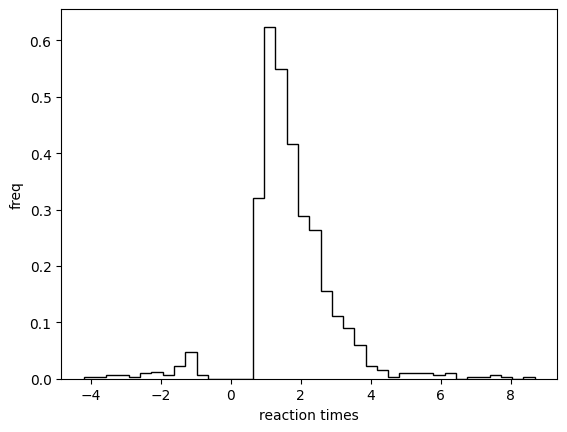

In [21]:
plt.hist(
    np.squeeze(out[0]) * np.squeeze(out[1]), histtype="step", bins=40, color="black", density=True
)
plt.xlabel("reaction times")
plt.ylabel("freq")
plt.show()

In [6]:
# Get data into format accepted by hddm package (below)
data = pd.DataFrame(np.stack([np.squeeze(out[0]), np.squeeze(out[1])]).T, columns = ['rt', 'response'])
data['subject'] = 0
data

,rt,response,subject
0,0.875999,1.0,0
1,1.184995,1.0,0
2,1.253994,1.0,0
3,1.241994,1.0,0
4,1.367992,1.0,0
...,...,...,...
995,1.224994,1.0,0
996,1.552993,-1.0,0
997,1.046997,1.0,0
998,2.138021,1.0,0


In [7]:
class approx_dbm(object):
    """
    Markov chain approximation of a Brownian motion with drift
    We want to study the first passage time of a 'Brownian motion with drift' to two collapsing boundaries
    the boundaries are a - theta * t and -a + theta * t, this is so-called 'Angle' model
    """

    def __init__(self, mu, a, z, t_nd, theta, dt, Nx) -> None:
        self.mu = mu # drift coeff
        self.a = a  # boundaries start at 'a' and '-a'
        self.z = -a + z * (2 * a)  # starting point
        self.t_nd = t_nd # non-decision time
        self.theta = theta # boundary angle
        # boundaries
        # in the test case the boundaries are 1.5 - 0.3t and -1.5 + 0.3t
        # The boundaries collapse at t=5
        self.upper_bdy = lambda t: a - theta * t
        self.lower_bdy = lambda t: -a + theta * t
        # space and time discretization
        self.dt = dt
        self.Nx = Nx  # num of space steps
        dx = (2 * a) / Nx 
        self.dx = dx
        # starting point and initial distribution
        self.idx_z = self.pos2idx(z)  # index of starting point
        self.init_dist = np.zeros(self.Nx + 2)
        self.init_dist[self.idx_z] = 1
        # transitional probabilities
        m1 = mu * dt
        m2 = (mu * dt) ** 2 + self.dt
        self.p1 = (m2 / dx ** 2 + m1 / dx) / 2
        self.p2 = (m2 / dx ** 2 - m1 / dx) / 2
        assert self.p1 + self.p2 < 1, "p+=%.5f, p0=%.5f, p-=%.5f" % (
            self.p1,
            1 - self.p1 - self.p2,
            self.p2,
        )
        self.Update_AdjMat(t_nd)
    
    def pos2idx(self, x):
        """
        find the nearest spatial grid point of 'x'
        return the index
        """
        return int(round((x+self.a) / self.dx))
    
    def Update_AdjMat(self, t):
        """
        inhomogeneous transition probability matrix
        0, 1, ..., Nx are transient states
        Nx+1 is the absorbing state
        arguments:
        t - time
        endpoints: the jumping times of the current sample path
        """
        AdjMat = sp.dok_matrix((self.Nx + 2, self.Nx + 2))
        upper_idx = self.pos2idx(self.upper_bdy(t))
        lower_idx = self.pos2idx(self.lower_bdy(t))
        nz_dict = {
            # (lower_idx, self.Nx + 1): 1,
            # (upper_idx, self.Nx + 1): 1,
            (self.Nx + 1, self.Nx + 1): 1,
        }
        for i in range(lower_idx + 1):
            nz_dict[(i, self.Nx + 1)] = 1
        for i in range(upper_idx, self.Nx+1):
            nz_dict[(i, self.Nx + 1)] = 1
        for i in range(lower_idx + 1, upper_idx):
            nz_dict[(i, i - 1)] = self.p2
            nz_dict[(i, i)] = 1 - self.p1 - self.p2
            nz_dict[(i, i + 1)] = self.p1
        dict.update(AdjMat, nz_dict)
        self.AdjMat = sp.csr_matrix(AdjMat)

    def ExitDist(self, T):
        """
        compute the full distribution of X[T]
        where T is the first passage time
        by MATRIX MULTIPLICATION
        """
        T = T - self.t_nd
        dist_Xt = self.init_dist
        idx_T = int(round(T / self.dt))
        for t_step in range(idx_T):
            self.Update_AdjMat(t_step * self.dt)
            dist_Xt = dist_Xt @ self.AdjMat
        return dist_Xt

    def ExitProb_dp(self, T, s):
        """
        compute the probability of P(X[T]=s)
        where t is the first passage time
        by DYNAMIC PROGRAMMING based on SPARSE ADJACENCY MATRIX
        s: value in [-a, a]
        """
        T = T - self.t_nd
        idx_T = int(round(T / self.dt))
        idx_s = self.pos2idx(s)
        table = np.zeros((self.Nx + 2, idx_T))
        self.Update_AdjMat((idx_T - 1) * self.dt)
        table[:, [idx_T - 1]] = self.AdjMat[:, [idx_s]].toarray()
        for t_step in range(idx_T - 2, -1, -1):
            self.Update_AdjMat(t_step * self.dt)
            table[:, [t_step]] = self.AdjMat @ table[:, [t_step + 1]]
        return table[:, 0] @ self.init_dist

    def ExitProb_logdp(self, T, s):
        """
        compute the probability of P(X[T]=s) with a EXP scaling
        where t is the first passage time
        by DYNAMIC PROGRAMMING based on ADJACENCY MATRIX
        s: value in [-a, a]
        """
        T = T - self.t_nd
        idx_T = int(round(T / self.dt))
        idx_s = self.pos2idx(s)
        scaled_table = np.zeros((self.Nx + 2, idx_T))
        r = 0
        self.Update_AdjMat((idx_T - 1) * self.dt)
        scaled_table[:, [idx_T - 1]] = self.AdjMat[:, [idx_s]].toarray() / np.exp(r)
        for t_step in range(idx_T - 2, -1, -1):
            self.Update_AdjMat(t_step * self.dt)
            b = np.sum(self.AdjMat @ scaled_table[:, [t_step + 1]])
            r = r + np.log(b)
            scaled_table[:, [t_step]] = self.AdjMat @ scaled_table[:, [t_step + 1]] / b
        return scaled_table[:, 0] * np.exp(r) @ self.init_dist


The original process is a Brownian motion with drift:
$$
\mathrm{d}X(t)=\mu \mathrm{d}t+\mathrm{d}W(t)
$$
integrate it to get
$$
X(t)=z+\mu t+W(t)
$$
So
$$
X(t) \text{ hits } \pm a(t)\Leftrightarrow W(t)\text{ hits } \pm a(t)-z-\mu t
$$
#### A Note: 
The original boundaries are collapsing, using this transformation could lose that simplicity.

In [8]:
# Get the model
lan_angle = hddm.network_inspectors.get_torch_mlp(model='angle')

#### test 1: Set $\theta=0$, check if the approximate angle model gives the same results as the previous approximate vanilla drift-diffusion model.

Note that the space considered in angle model is $[-a,a]$, while that in DDM and wfpt is $[0, a]$.

Also the angle model implements the non-decision time.

##### 1.a Use the equivilent parameters in the last sanity check

In [9]:
mu = 0.2
a = 2
z = 0
t_nd = 0.5
theta = 0
mc = approx_dbm(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80)
mc0 = approx_hmc(mu=mu, sigma=1, a=2 * a, z=z + a, dt=0.001, Nx=80, verbose=False)


T = 5.5
prob1 = wfpt(T - t_nd, mu, 2 * a, z + a, 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=-mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=0) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, -1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0,0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))


reference:    0.02547652896815553

approx angle: 0.0254767722309908
approx ddm:   0.0254767722309908
relative err: 0.00095%

lan:          0.009977403
relative err: 60.83688%


##### 1.b Use a more realistic paramter set

In [10]:
mu = 1
a = 1.5
z = 0.5
t = 0.5
theta = 0
mc = approx_dbm(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80)
mc0 = approx_hmc(mu=mu, sigma=1, a=2 * a, z=z + a, dt=0.001, Nx=80, verbose=False)
T = 1
prob1 = wfpt(T - t_nd, mu, 2 * a, z + a, 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=-mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=0) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, -1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0,0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))

print()
print("--- With Denser Grid ---")
mc = approx_dbm(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.0001, Nx=250)
mc0 = approx_hmc(mu=mu, sigma=1, a=2 * a, z=z + a, dt=0.0001, Nx=250, verbose=False)
T = 1
prob1 = wfpt(T - t_nd, mu, 2 * a, z + a, 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=-mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=0) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, -1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0,0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))


reference:    0.00435651492534191

approx angle: 0.004614753474919366
approx ddm:   0.004614753474919366
relative err: 5.92764%

lan:          0.029070139
relative err: 567.27968%

--- With Denser Grid ---
reference:    0.00435651492534191

approx angle: 0.0042793064917882526
approx ddm:   0.0042793064917882526
relative err: 1.77225%

lan:          0.029070139
relative err: 567.27968%


##### 1.c the same as 1.b, but compute the upper boundary crossing probability instead

In [11]:
mu = 1
a = 1.5
z = 0.5
t = 0.5
theta = 0
mc = approx_dbm(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80)
mc0 = approx_hmc(mu=mu, sigma=1, a=2 * a, z=z + a, dt=0.001, Nx=80, verbose=False)
T = 1
prob1 = wfpt(T - t_nd, -mu, 2 * a, 2*a-(z + a), 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=mc0.a) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, 1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0,0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))

print()
print("--- With Denser Grid ---")
mc = approx_dbm(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.0001, Nx=250)
mc0 = approx_hmc(mu=mu, sigma=1, a=2 * a, z=z + a, dt=0.0001, Nx=250, verbose=False)
T = 1
prob1 = wfpt(T - t_nd, -mu, 2 * a, 2*a-(z + a), 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=mc0.a) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, 1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0,0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))

reference:    0.8787825787695689

approx angle: 0.8791550046745211
approx ddm:   0.8791550046745211
relative err: 0.04238%

lan:          0.6082513
relative err: 30.78478%

--- With Denser Grid ---
reference:    0.8787825787695689

approx angle: 0.8788150032768899
approx ddm:   0.8788150032768899
relative err: 0.00369%

lan:          0.6082513
relative err: 30.78478%


#### test 2: For the Angle model with $\theta\neq0$

In [23]:
mu = 1
a = 1.5
z = 0.5
t = 0.5
theta = 0
mc = approx_dbm(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.001, Nx=80)
mc0 = approx_hmc(mu=mu, sigma=1, a=2 * a, z=z + a, dt=0.001, Nx=80, verbose=False)
T = 1
# prob1 = wfpt(T - t_nd, -mu, 2 * a, 2*a-(z + a), 1e-10)
# prob2 = mc.ExitProb_dp(T=T, s=mc.a) / mc.dt
# prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=mc0.a) / mc0.dt
T_list = np.linspace(0.6, 5, 1000)
prob1_list = []
prob4_list = []
for T in T_list:
    network_input = np.array([[mu, a, z, t_nd, theta, T, 1]]).astype(np.float32)
    prob1 = wfpt(T - t_nd, -mu, 2 * a, 2*a-(0 + a), 1e-10)
    prob4 = np.exp(lan_angle(network_input))[0,0]
    prob1_list.append(prob1)
    prob4_list.append(prob4)


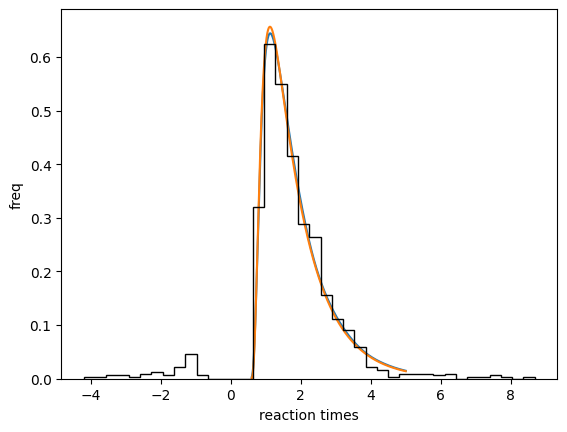

In [24]:
import matplotlib.pyplot as plt
plt.plot(T_list, prob4_list)
plt.plot(T_list, prob1_list)

plt.hist(
    np.squeeze(out[0]) * np.squeeze(out[1]), histtype="step", bins=40, color="black", density=True
)
plt.xlabel("reaction times")
plt.ylabel("freq")
plt.show()

In [ ]:
    


print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))

print()
print("--- With Denser Grid ---")
mc = approx_dbm(mu=mu, a=a, z=z, t_nd=t_nd, theta=theta, dt=0.0001, Nx=250)
mc0 = approx_hmc(mu=mu, sigma=1, a=2 * a, z=z + a, dt=0.0001, Nx=250, verbose=False)
T = 1
prob1 = wfpt(T - t_nd, -mu, 2 * a, 2*a-(z + a), 1e-10)
prob2 = mc.ExitProb_dp(T=T, s=mc.a) / mc.dt
prob3 = mc0.ExitProb_dp1(T=T - t_nd, s=mc0.a) / mc0.dt
network_input = np.array([[mu, a, z, t_nd, theta, T, 1]]).astype(np.float32)
prob4 = np.exp(lan_angle(network_input))[0,0]

print("reference:   ", prob1)
print()
print("approx angle:", prob2)
print("approx ddm:  ", prob3)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob2) / prob1))
print()
print("lan:         ", prob4)
print("relative err:", "{:.5%}".format(np.abs(prob1 - prob4) / prob1))